In [33]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load data and look around

In [3]:
products = pd.read_csv("data/product.csv")

In [4]:
products.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [10]:
products.DEPARTMENT.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [11]:
products.BRAND.unique()

array(['National', 'Private'], dtype=object)

In [5]:
transactions = pd.read_csv("data/transaction_data.csv")

In [6]:
transactions.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


Quoting dataset description:

> The variable sales_value in this table is the amount of dollars received by the retailer on the
sale of the specific product, taking the coupon match and loyalty card discount into account.
It is not the actual price paid by the customer. If a customer uses a coupon, the actual price
paid will be less than the sales_value because the manufacturer issuing the coupon will
reimburse the retailer for the amount of the coupon.

> To calculate the actual product prices, use the formulas below:

> Loyalty card price = (sales_value – (retail_disc + coupon_match_disc))/quantity

> Non-loyalty card price = (sales_value – (coupon_match_disc))/quantity

In [9]:
transactions.WEEK_NO.min(), transactions.WEEK_NO.max()

(1, 102)

We have data from 2 years

In [12]:
household_demographic = pd.read_csv("data/hh_demographic.csv")

In [13]:
household_demographic.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [63]:
def plot_trend(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10,8))
    
    plt.plot(x, y, label="Actual values")
    
    reg = LinearRegression()
    x_reg = x.to_numpy().reshape(-1, 1)
    reg.fit(x_reg, y)
    plt.plot(x, reg.predict(x_reg), label="Linear trend")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Overall spending of a household in a week

In [14]:
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum()

In [15]:
weekly.head()

household_key  WEEK_NO
1              8          78.66
               10         41.10
               13         26.90
               14         63.43
               15         53.45
Name: SALES_VALUE, dtype: float64

Let's look at average spending in a household over time

In [18]:
avg_weekly = weekly.groupby("WEEK_NO").mean()

In [20]:
avg_weekly = avg_weekly.sort_index()

In [21]:
avg_weekly.head()

WEEK_NO
1    59.217727
2    61.836286
3    59.202632
4    59.133296
5    54.431946
Name: SALES_VALUE, dtype: float64

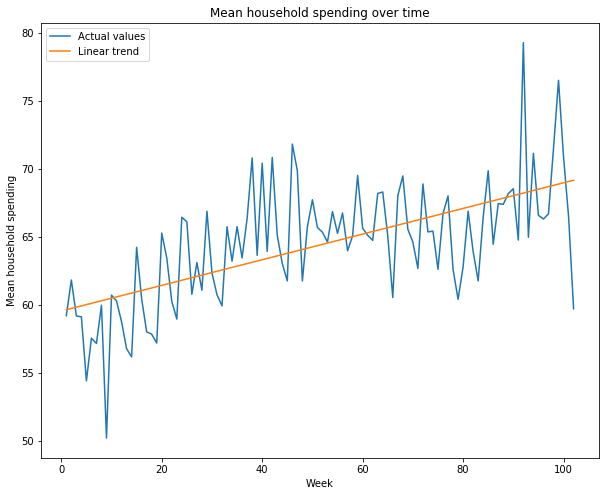

In [64]:
plot_trend(avg_weekly.index, avg_weekly, "Week", "Mean household spending", "Mean household spending over time")

In [66]:
avg_weekly.describe()

count    102.000000
mean      64.409022
std        4.508112
min       50.231785
25%       61.256162
50%       65.026997
75%       66.831610
max       79.266716
Name: SALES_VALUE, dtype: float64

Spending does seem to increase over time overall and there are big fluctuations week-by-week, maybe because people tend to buy stuff at some specific point in time - like at the beginning of the month.

In [82]:
med_weekly = weekly.groupby("WEEK_NO").median()

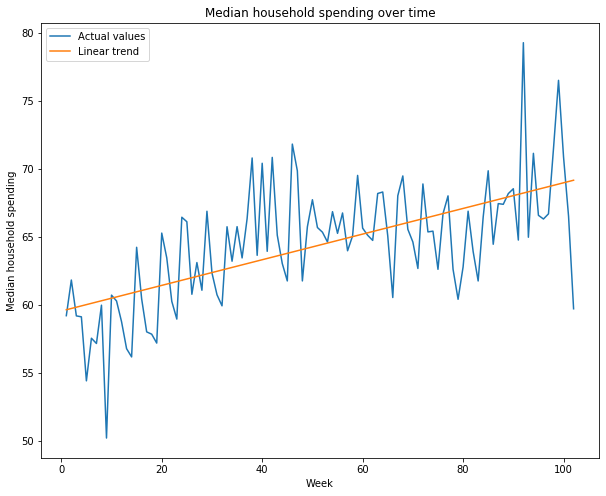

In [83]:
plot_trend(avg_weekly.index, avg_weekly, "Week", "Median household spending", "Median household spending over time")

# Monthly spending

In [79]:
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [90]:
transactions["DAY_OF_MONTH"] = ((transactions["DAY"]) % 30)

In [91]:
monthly = transactions.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum()

In [113]:
monthly = monthly.reset_index()

In [117]:
avg_monthly = monthly.groupby("MONTH")["SALES_VALUE"].mean()

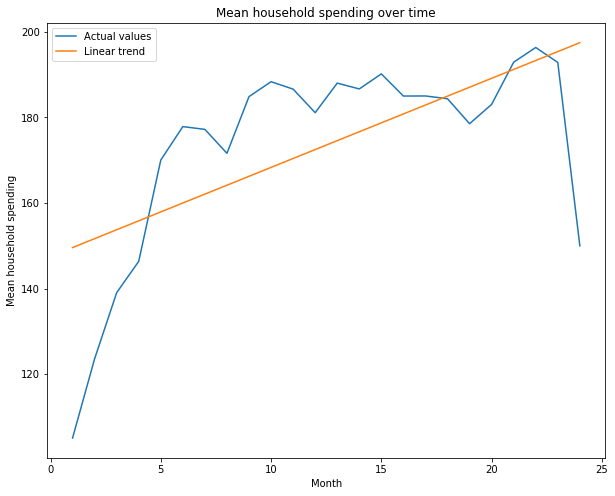

In [118]:
plot_trend(avg_monthly.index, avg_monthly, "Month", "Mean household spending", "Mean household spending over time")

In [95]:
transactions[transactions["MONTH"] == 1]["DAY_OF_MONTH"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [96]:
transactions[transactions["MONTH"] == 23]["DAY_OF_MONTH"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [94]:
transactions[transactions["MONTH"] == 24]["DAY_OF_MONTH"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

The monthly data is far less noisy - has a big growth in the first 5 months, then it reduces pace but overall is still growing, but much more slowly. The big drop at the end is likely due to the fact that the last month is underrepresented - the sales are only up to 20th day.

In [119]:
monthly_cleaned = monthly[monthly["MONTH"] != 24]

In [123]:
avg_monthly = monthly_cleaned.groupby("MONTH")["SALES_VALUE"].mean()

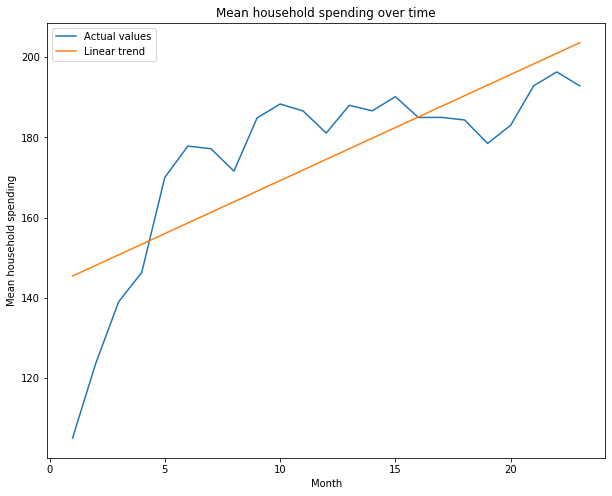

In [124]:
plot_trend(avg_monthly.index, avg_monthly, "Month", "Mean household spending", "Mean household spending over time")

Let's compare it to number of products bought instead of costs.

In [125]:
quantities = transactions.groupby(["household_key", "MONTH"])["QUANTITY"].sum().groupby("MONTH").mean()

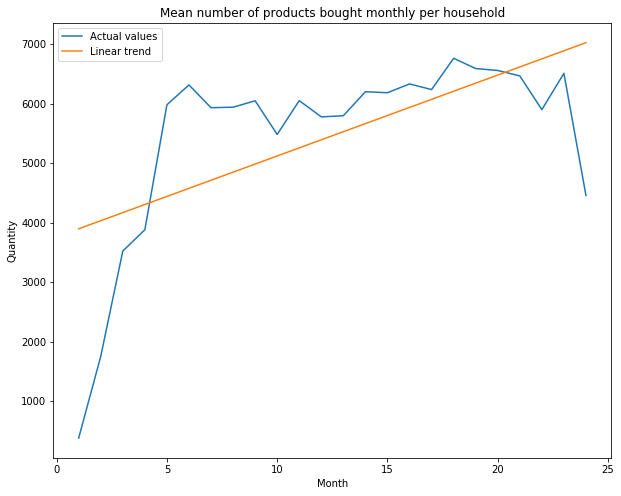

In [126]:
plot_trend(quantities.index, quantities, "Month", "Quantity", "Mean number of products bought monthly per household")

# Are people buying cheaper / more expensive products over time?

In [127]:
transactions["UNIT_PRICE"] = transactions["SALES_VALUE"] / transactions["QUANTITY"] # we deliberately ignore discounts as we want to account the fact that people may specifically want to buy discounted products

In [133]:
counted_transactions = transactions[transactions["QUANTITY"] > 0]

In [134]:
counted_transactions["UNIT_PRICE"].describe()

count    2.581266e+06
mean     2.436950e+00
std      2.720470e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.920000e+00
75%      2.990000e+00
max      4.999900e+02
Name: UNIT_PRICE, dtype: float64

In [135]:
avg_product_price = counted_transactions.groupby(["MONTH"])["UNIT_PRICE"].mean()

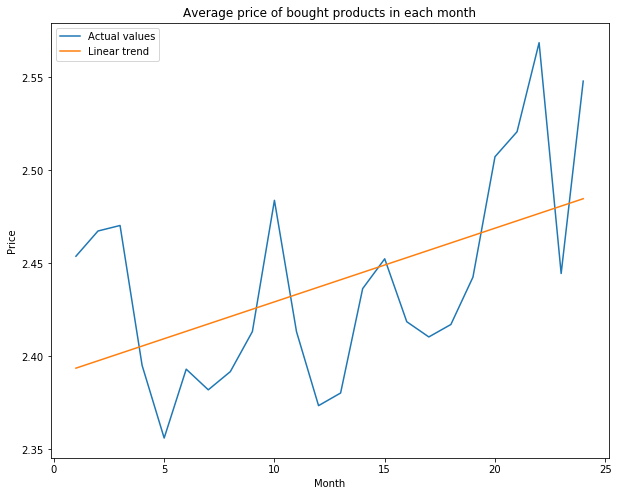

In [136]:
plot_trend(avg_product_price.index, avg_product_price, "Month", "Price", "Average price of bought products in each month")

# Spending on days of month / week

We analyze how days of week are distributed

In [140]:
transactions.groupby("WEEK_NO")["DAY"].unique()

WEEK_NO
1                          [1, 2, 3, 4, 5]
2                 [6, 7, 8, 9, 10, 11, 12]
3             [13, 14, 15, 16, 17, 18, 19]
4             [20, 21, 22, 23, 24, 25, 26]
5             [27, 28, 29, 30, 31, 32, 33]
                      ...                 
98     [678, 679, 680, 681, 682, 683, 684]
99     [685, 686, 687, 688, 689, 690, 691]
100    [692, 693, 694, 695, 696, 697, 698]
101    [699, 700, 701, 702, 703, 704, 705]
102         [706, 707, 708, 709, 710, 711]
Name: DAY, Length: 102, dtype: object

We can see that first and last week are underrepresented, so we will drop them.
The second week starts at 6 so we will devise this to be 1st week day.

Unfortunately we cannot exactly say which day is which weekday, 1st day can be Monday or Sunday probably. We will try to draw hypotheses if possible.

In [146]:
transactions_dow = transactions[(transactions["WEEK_NO"] != 1) & (transactions["WEEK_NO"] != 102)].copy()

In [147]:
(transactions_dow.groupby("WEEK_NO")["DAY"].unique().apply(len) == 7).all()

True

In [148]:
transactions_dow["DAY_OF_WEEK"] = (transactions_dow["DAY"] - 6) % 7 + 1

In [152]:
dow = transactions_dow.groupby(["household_key", "DAY_OF_WEEK"])["SALES_VALUE"].sum().groupby("DAY_OF_WEEK").mean()

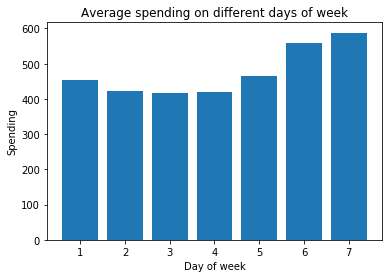

In [157]:
plt.bar(dow.index, dow)
plt.title("Average spending on different days of week")
plt.xlabel("Day of week")
plt.ylabel("Spending")
plt.show()

It is only a hypothesis, but it seems that 1 = Monday indeed, as the last two days get higher spendings and people tend to go shopping on the weekends (at least in countries when most shops are open on Sundays, but if this shop was closed altogether it would have 0 sales or small sales in only specific shopping points, which would be clear from the plot).

So we can conjecture that 1 = Monday, 7 = Sunday and people do most sales on the weekend (which seems reasonable as they have more time) and also a bit more than usual on Friday (after work, maybe in preparation for the weekend) and Mondays (maybe to refill after a weekend).

In [158]:
dom = transactions_dow.groupby(["household_key", "DAY_OF_MONTH"])["SALES_VALUE"].sum().groupby("DAY_OF_MONTH").mean()

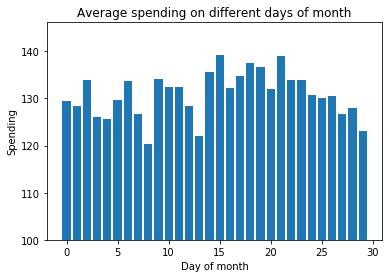

In [161]:
plt.bar(dom.index, dom)
plt.title("Average spending on different days of month")
plt.xlabel("Day of month")
plt.ylabel("Spending")
plt.ylim(100) # I want to see differences clearer thus alter the axis, normally not the best idea
plt.show()

The differences between days of the month don't seem to be very big.

One issue is that we only approximate days of the month as we don't even know if we start in January (although we might try such an assumption). 
But it seems there are no clear trends on spending here (but further research may be done).

# Weekly spending in various categor

In [167]:
transactions_demographic = transactions.merge(household_demographic, on="household_key")

In [168]:
transactions_demographic.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,MONTH,DAY_OF_MONTH,UNIT_PRICE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,...,1,1,2.19,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,...,1,1,2.99,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,...,1,1,3.09,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,...,1,1,2.50,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,...,1,1,0.60,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown


Let's see what demographic features we can look at:

In [172]:
sorted(household_demographic.AGE_DESC.unique())

['19-24', '25-34', '35-44', '45-54', '55-64', '65+']

In [174]:
household_demographic.INCOME_DESC.unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [176]:
household_demographic.HOUSEHOLD_SIZE_DESC.unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

In [177]:
household_demographic.HOMEOWNER_DESC.unique()

array(['Homeowner', 'Unknown', 'Renter', 'Probable Renter',
       'Probable Owner'], dtype=object)

In [190]:
def analyze_categories(data, category_column, statistic_computation, sort=True, show_separate=False):
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))
    
    if show_separate:
        for cat, stat in zip(values, stats):
            print(cat)
            plot_trend(stat.index, stat, "", "", cat)
    
    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):
        plt.plot(stat.index, stat, label=cat)
    #plt.xlabel("TODO")
    plt.title("Comparison over " + category_column)
    plt.legend()
    plt.show()

In [191]:
def stat_mean_monthly_spending(data):
    return data.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().groupby("MONTH").mean()

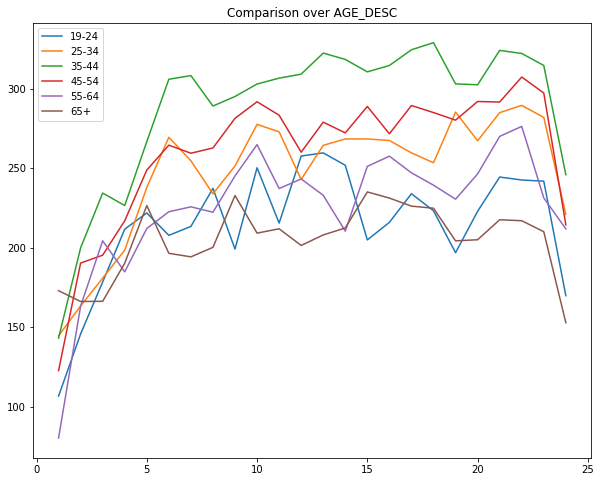

In [192]:
analyze_categories(transactions_demographic, "AGE_DESC", stat_mean_monthly_spending)

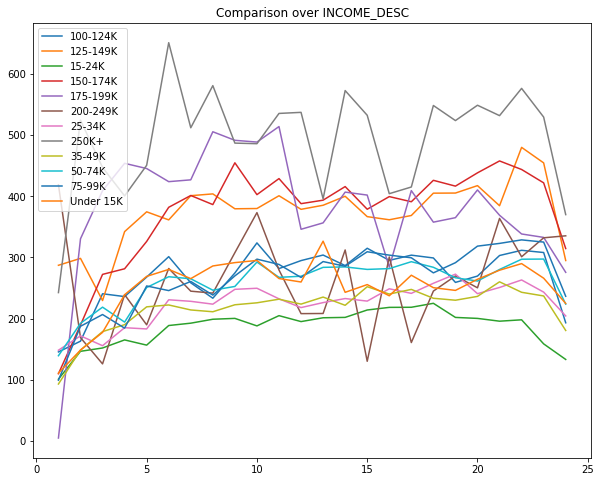

In [193]:
analyze_categories(transactions_demographic, "INCOME_DESC", stat_mean_monthly_spending)

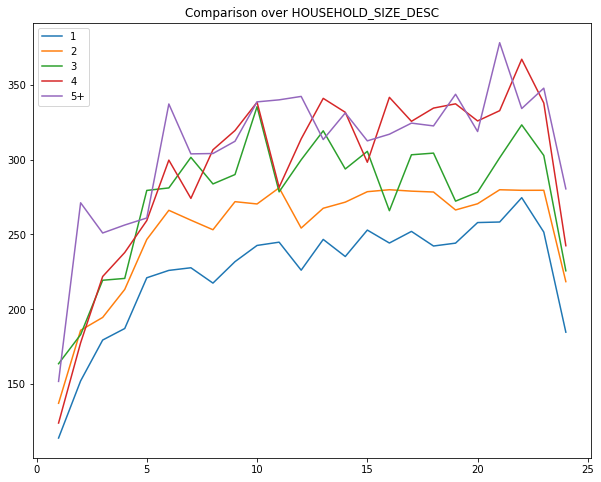

In [194]:
analyze_categories(transactions_demographic, "HOUSEHOLD_SIZE_DESC", stat_mean_monthly_spending)

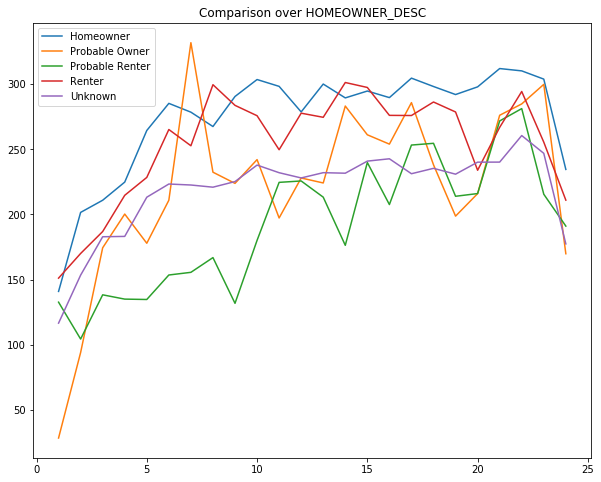

In [195]:
analyze_categories(transactions_demographic, "HOMEOWNER_DESC", stat_mean_monthly_spending)